In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.metrics import accuracy_score, log_loss
from tqdm import tqdm

# Fonctions

## La fonction d'initialisation

\begin{align*}
\LARGE 
W^ { [c] } \in \mathbb{R} ^ {n ^ {[c]} ~ \times ~ n ^ {[c ~ - ~ 1]} } 
\end{align*}

\begin{align*}
\LARGE 
b^ { [c] } \in \mathbb{R} ^ {n ^ {[c]} ~ \times ~ 1}
\end{align*}

In [2]:
def initialisation(dimensions):
    
    parametres = {}
    
    c = len(dimensions)
    
    for c in range(1, c):
        parametres['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c -1])
        parametres['b' + str(c)] = np.random.randn(dimensions[c], 1)

    return parametres

## Teste de la fonction initialisation

In [3]:
parametres = initialisation([2, 32, 32, 2])
for key, val in parametres.items():
    print(key, val.shape)

W1 (32, 2)
b1 (32, 1)
W2 (32, 32)
b2 (32, 1)
W3 (2, 32)
b3 (2, 1)


## La fonction de propagation vers l'avant

\begin{align*}
\LARGE 
Z^ { [c] } = W ^ {[c] } . Y^ {[c ~ - ~ 1]} + b^ {[c] }
\end{align*}

\begin{align*}
\LARGE 
Y^ { [c] } =  \frac {1} {1 + e ^ {-Z ^ {[c] } }}
\end{align*}

In [4]:
def forward_propagation(X, parametres):
    
    activations = {'A0' : X}
    
    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        Z = parametres['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametres['b' + str(c)]
        activations['A' + str(c)]  = 1 /(1 + np.exp(-Z))

    return activations

## Teste de la propagation vers l'avant

In [5]:
# initialisation des valeurs de X et y 
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

In [7]:
activations = forward_propagation(X, parametres)
for key, val in activations.items():
    print(key, val.shape) 

A0 (2, 100)
A1 (32, 100)
A2 (32, 100)
A3 (2, 100)


## Fonction de la rétro-propagation

\begin{align*}
\LARGE 
dZ^ { [c_{f} ]} = Y ^ {[c_{f} ]} - y
\end{align*}

\begin{align*}
\LARGE 
dW^ { [c]} = \frac {1} {m} \times dZ ^ {[c]} . Y ^ {[c -1]^{T}}
\end{align*}

\begin{align*}
\LARGE 
db^ { [c ]} = \frac {1} {m} \sum_{axe1} dZ ^ {[c]} 
\end{align*}

\begin{align*}
\LARGE 
dZ^ { [c - 1]} = W ^ {[c]^{T}} \times dZ^ { [c]} \times Y ^ {[c -1]} (1 - Y ^ {[c -1]})
\end{align*}

In [8]:
def back_propagation(y, parametres, activations):

    m = y.shape[1]
    C = len(parametres) // 2
    
    dZ = activations['A' + str(C)] - y
    gradients = {}
    
    for c in reversed(range(1, C + 1)):
        gradients['dW' + str(c)] = 1 / m * np.dot(dZ, activations['A' + str(c - 1)].T) 
        gradients['db' + str(c)] = 1 / m * np.sum(dZ, axis=1, keepdims = True)
        if c > 1:
            dZ = np.dot(parametres['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])
 
    return gradients

## Teste de la rétro-propagation

In [9]:
grad = back_propagation(y, parametres, activations)

for key, val in grad.items():
    print(key, val.shape) 

dW3 (2, 32)
db3 (2, 1)
dW2 (32, 32)
db2 (32, 1)
dW1 (32, 2)
db1 (32, 1)


\begin{align*}
\LARGE 
W^ { [c]} = W^ {[c]} - \alpha \times dW ^ {[c]} 
\end{align*}

\begin{align*}
\LARGE 
b^ { [c]} = b^ {[c]} - \alpha \times db ^ {[c]} 
\end{align*}

In [10]:
def update(gradients, parametres, learning_rate):

    C = len(parametres) // 2
    
    for c in range(1, C + 1):
        parametres['W' + str(c)] = parametres['W' + str(c)] - learning_rate * gradients['dW' + str(c)]
        parametres['b' + str(c)] = parametres['b' + str(c)] - learning_rate * gradients['db' + str(c)]
    return parametres

In [11]:
def predict(X, parametres):
    activations = forward_propagation(X, parametres)
    C = len(parametres) // 2
    Af = activations['A' + str(C)]
    return Af >= 0.5

In [12]:
def neural_network(X, y, hidden_layers = (32, 32, 32), learning_rate = 0.1, n_iter = 1000):
    
    np.random.seed(0)
    # initialisation parametres
    dimensions = list(hidden_layers)
    dimensions.insert(0, X.shape[0])
    dimensions.append(y.shape[0])
    parametres = initialisation(dimensions)

    train_loss = []
    train_acc = []

    # gradient descent
    for i in tqdm(range(n_iter)):
        
        activations = forward_propagation(X, parametres)
        gradients = back_propagation(y, parametres, activations)
        parametres = update(gradients, parametres, learning_rate)
    
        if i %10 == 0 :
            C = len(parametres) // 2
        
            # Analyse des courbes d'apprentissage
            train_loss.append(log_loss(y, activations['A' + str(C)]))
            y_pred = predict(X, parametres)
            current_accuracy = accuracy_score(y.flatten(), y_pred.flatten())
            train_acc.append(current_accuracy)

    #Visualisation des résultats
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
    ax[0].plot(train_loss, label= 'train_loss')
    ax[0].legend()
    
    ax[1].plot(train_acc, label= 'train_acc')
    ax[1].legend()
    
  #  visualisation(X, y, parametres, ax)

    ax[2].scatter(X[0, :], X[1, :], c=y, cmap='summer')
    plt.show()

    return parametres

# Dataset

dimensions de X: (2, 100)
dimensions de y: (1, 100)


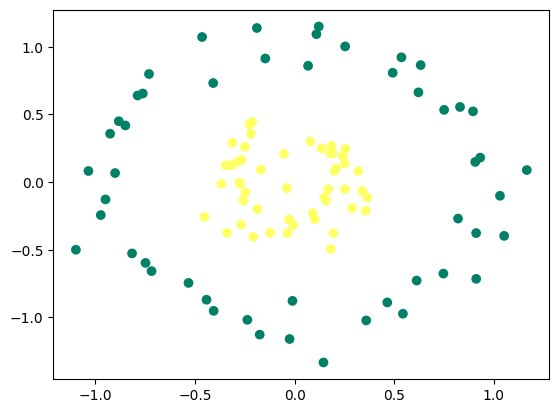

In [13]:
X, y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
X = X.T
y = y.reshape((1, y.shape[0]))

print('dimensions de X:', X.shape)
print('dimensions de y:', y.shape)

plt.scatter(X[0, :], X[1, :], c=y, cmap='summer')
plt.show()

In [15]:
X 

array([[-0.94957536,  0.09138459,  0.93214973,  0.20734231, -0.36750218,
         0.2532073 , -0.40867925, -0.27450909,  0.24224991,  0.158872  ,
         0.17984262,  0.19490678, -0.18640787,  0.12157863,  0.49287043,
        -0.81607272, -0.88256159, -0.90136274, -0.44207091,  0.63318667,
         0.74738819,  0.07947606,  0.83076047, -0.28699936,  0.91209859,
         1.05235514,  0.62194713,  0.35809164, -0.03880452, -0.16849662,
         0.18452538, -0.33911143,  0.10167817, -0.24980872,  0.3198604 ,
        -0.97315797, -0.73097704,  0.25473331, -0.21290872, -0.27834832,
         1.16614005,  0.19060984,  0.54409779,  0.35966887,  0.89607094,
        -0.1892848 , -0.46440441,  0.46542725, -0.02494581,  0.75084969,
        -0.02786858, -0.05339409,  0.90718408, -0.40622936, -0.74854102,
         0.36512093,  0.10964665, -0.17507169, -0.92614192,  0.25215638,
         0.2540514 , -0.71813367, -0.21920932,  0.20066063, -0.45295043,
        -0.26890899, -0.53262577, -0.12304334, -0.1

100%|██████████| 1000/1000 [00:00<00:00, 1988.84it/s]


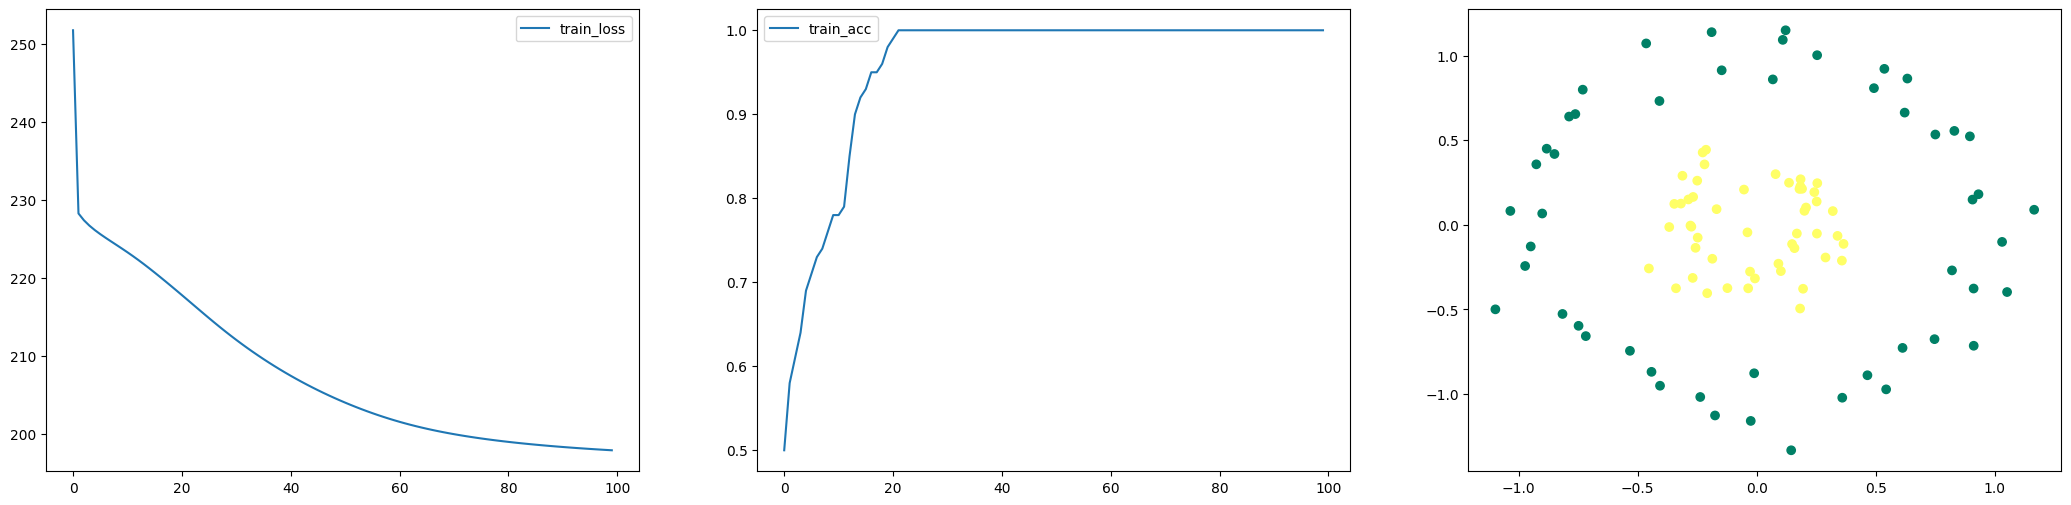

In [16]:
neural_network(X, y);

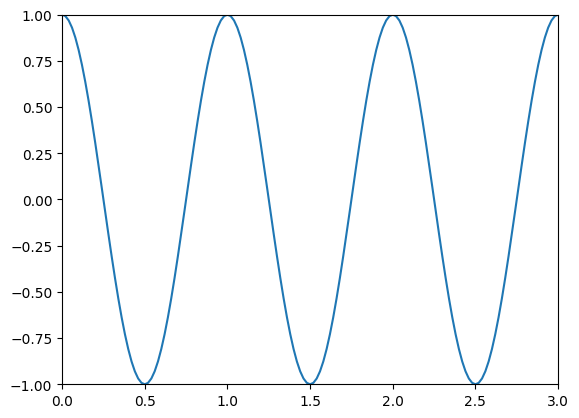

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

k = 2*np.pi
w = 2*np.pi
dt = 0.01

xmin = 0
xmax = 3
nbx = 151

x = np.linspace(xmin, xmax, nbx)

fig = plt.figure() # initialise la figure
line, = plt.plot([], []) 
plt.xlim(xmin, xmax)
plt.ylim(-1, 1)

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
 
ani = animation.FuncAnimation(fig, animate, frames=100, blit=True, interval=20, repeat=False)

plt.show()

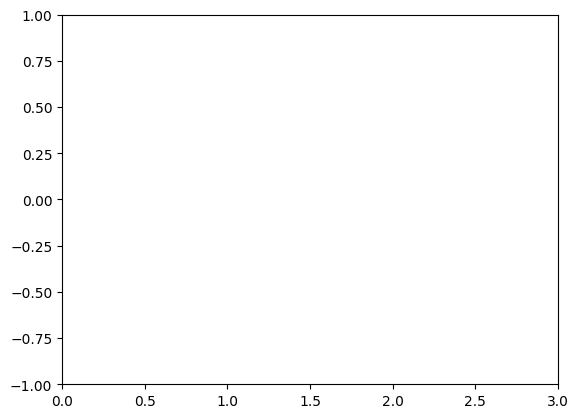

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

k = 2*np.pi
w = 2*np.pi
dt = 0.01

xmin = 0
xmax = 3
nbx = 151

x = np.linspace(xmin, xmax, nbx)

fig = plt.figure() # initialise la figure
line, = plt.plot([], []) 
plt.xlim(xmin, xmax)
plt.ylim(-1, 1)

def init():
    line.set_data([], [])
    return line,

def animate(i): 
    t = i * dt
    y = np.cos(k*x - w*t)
    line.set_data(x, y)
    return line,
 
ani = animation.FuncAnimation(fig, animate, init_func=init, frames=100, blit=True, interval=20, repeat=False)

plt.show()

C:\Users\Jean-Luc\AppData\Local\Temp\ipykernel_21720\2596873959.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')
MovieWriter imagemagick unavailable; using Pillow instead.


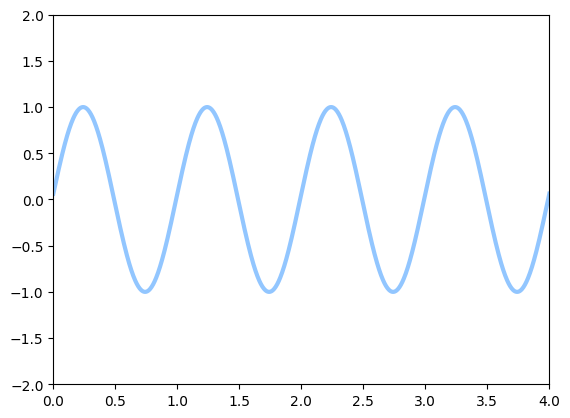

In [20]:

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('seaborn-pastel')


fig = plt.figure()
ax = plt.axes(xlim=(0, 4), ylim=(-2, 2))
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=20, blit=True)


anim.save('sine_wave.gif', writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


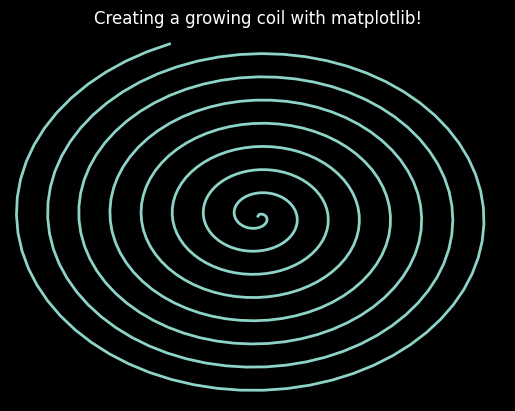

In [21]:
import matplotlib.pyplot as plt 
import matplotlib.animation as animation 
import numpy as np 
plt.style.use('dark_background')

fig = plt.figure() 
ax = plt.axes(xlim=(-50, 50), ylim=(-50, 50)) 
line, = ax.plot([], [], lw=2) 

# initialization function 
def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 

# lists to store x and y axis points 
xdata, ydata = [], [] 

# animation function 
def animate(i): 
    # t is a parameter 
    t = 0.1*i 
    
    # x, y values to be plotted 
    x = t*np.sin(t) 
    y = t*np.cos(t) 
    
    # appending new points to x, y axes points list 
    xdata.append(x) 
    ydata.append(y) 
    line.set_data(xdata, ydata) 
    return line, 
    
# setting a title for the plot 
plt.title('Creating a growing coil with matplotlib!') 
# hiding the axis details 
plt.axis('off') 

# call the animator	 
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=20, blit=True) 

# save the animation as mp4 video file 
anim.save('coil.gif',writer='imagemagick') 

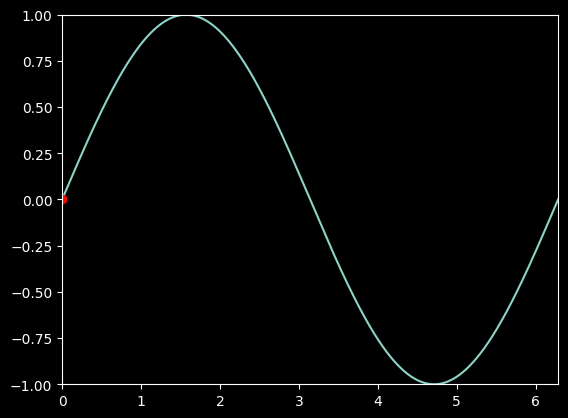

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
s = np.sin(t)
l = plt.plot(t, s)

ax = plt.axis([0,TWOPI,-1,1])

redDot, = plt.plot([0], [np.sin(0)], 'ro')

def animate(i):
    redDot.set_data(i, np.sin(i))
    return redDot,

# create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=np.arange(0.0, TWOPI, 0.1), \
                                      interval=10, blit=True, repeat=True)

plt.show()

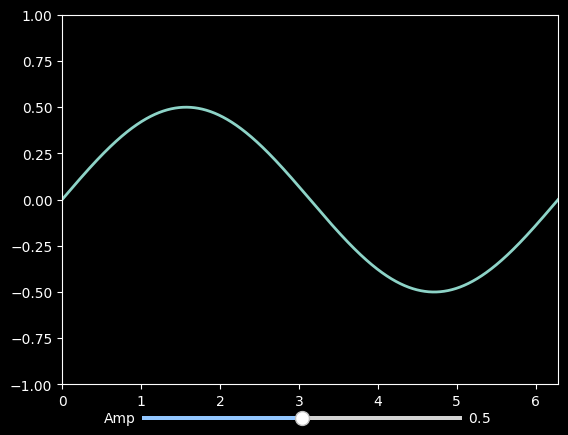

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.widgets import Slider

TWOPI = 2*np.pi

fig, ax = plt.subplots()

t = np.arange(0.0, TWOPI, 0.001)
initial_amp = .5
s = initial_amp*np.sin(t)
l, = plt.plot(t, s, lw=2)

ax = plt.axis([0,TWOPI,-1,1])

axamp = plt.axes([0.25, .03, 0.50, 0.02])
# Slider
samp = Slider(axamp, 'Amp', 0, 1, valinit=initial_amp)

def update(val):
    # amp is the current value of the slider
    amp = samp.val
    # update curve
    l.set_ydata(amp*np.sin(t))
    # redraw canvas while idle
    fig.canvas.draw_idle()

# call update function on slider value change
samp.on_changed(update)

plt.show()

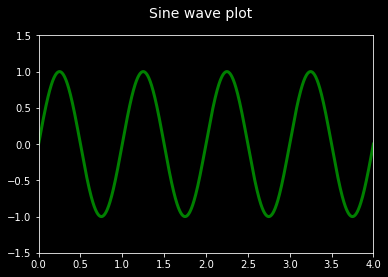

In [51]:
# importing required libraries
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.animation as animation
from IPython import display
  
# initializing a figure
fig = plt.figure()
  
# labeling the x-axis and y-axis
axis = plt.axes(xlim=(0, 4),  ylim=(-1.5, 1.5))
  
# initializing a line variable
line, = axis.plot([], [], lw=3)
  
def animate(frame_number):
    x = np.linspace(0, 4, 1000)
  
    # plots a sine graph
    y = np.sin(2 * np.pi * (x - 0.01 * frame_number))
    line.set_data(x, y)
    line.set_color('green')
    return line,
  
  
anim = animation.FuncAnimation(fig, animate, frames=100, 
                               interval=20, blit=True)
fig.suptitle('Sine wave plot', fontsize=14)
  
# converting to an html5 video
#video = anim.to_html5_video()
  
# embedding for the video
#html = display.HTML(video)
  
# draw the animation
#display.display(html)
plt.show()
plt.close()

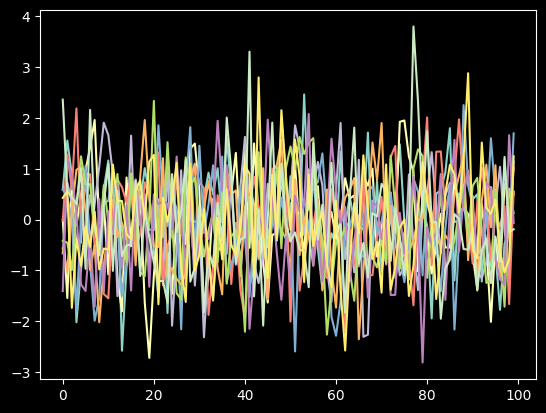

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

ims = []

for i in range(10):
        rand = np.random.randn(100)     #Générer 100 nombres aléatoires
        im = plt.plot(rand)             #Graphique des nombres aléatoires
        ims.append(im)                  #Ajouter un graphique au tableau ims

#Afficher 10 graphiques toutes les 100 ms
ani = animation.ArtistAnimation(fig, ims, interval=100)
plt.show()


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()

def plot(data):
    plt.cla()                      #Effacer le graphique actuellement dessiné
    rand = np.random.randn(100)    #Générer 100 nombres aléatoires
    im = plt.plot(rand)            #Générer un graphique

ani = animation.FuncAnimation(fig, plot, interval=100)
plt.show()

C:\Users\Jean-Luc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<Figure size 640x480 with 0 Axes>